Data Preparation

In [1]:
import pandas as pd
import numpy as np

# Load data
fear_greed = pd.read_csv("fear_greed_index.csv", parse_dates=["date"])
trades = pd.read_csv("historical_data.csv")

# Clean column names
trades.columns = [c.lower().replace(" ", "_") for c in trades.columns]

# Parse datetime
trades["timestamp_ist"] = pd.to_datetime(trades["timestamp_ist"], format="%d-%m-%Y %H:%M")

# Merge by date
trades["trade_date"] = trades["timestamp_ist"].dt.date
fear_greed["date"] = pd.to_datetime(fear_greed["date"]).dt.date

df = trades.merge(fear_greed, left_on="trade_date", right_on="date", how="left")


In [2]:
# Win rate & PnL
df["profitable"] = (df["closed_pnl"] > 0).astype(int)

acct_stats = df.groupby("account").agg(
    total_trades=("closed_pnl","count"),
    win_rate=("profitable","mean"),
    avg_pnl=("closed_pnl","mean"),
    median_pnl=("closed_pnl","median"),
    std_pnl=("closed_pnl","std"),
    avg_fee=("fee","mean")
).reset_index()

# By sentiment
sentiment_stats = df.groupby("classification").agg(
    trades=("closed_pnl","count"),
    avg_pnl=("closed_pnl","mean"),
    win_rate=("profitable","mean")
).reset_index()


Matplotlib is building the font cache; this may take a moment.


<Figure size 1000x600 with 0 Axes>

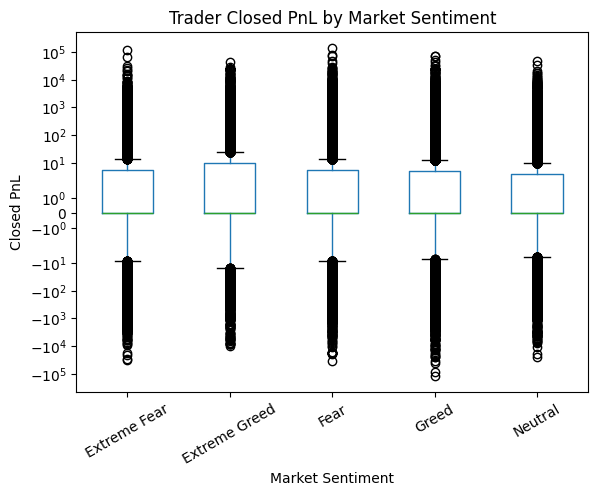

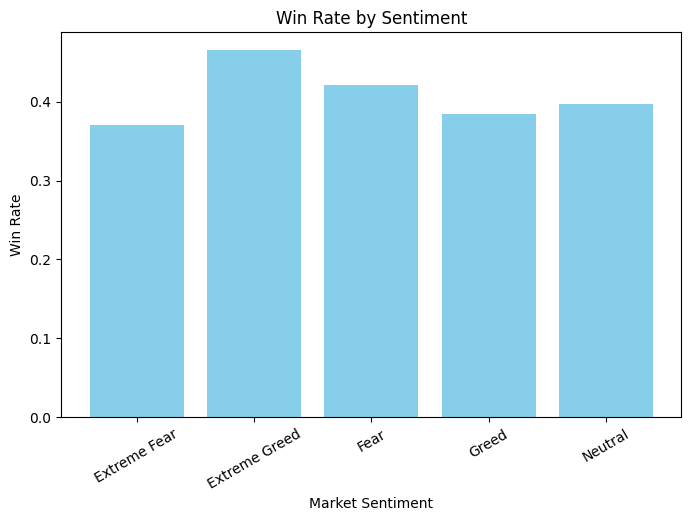

In [4]:
import matplotlib.pyplot as plt

# Boxplot of Closed PnL by sentiment
plt.figure(figsize=(10,6))
df.boxplot(column="closed_pnl", by="classification", grid=False)
plt.title("Trader Closed PnL by Market Sentiment")
plt.suptitle("")
plt.yscale("symlog")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.xticks(rotation=30)
plt.show()

# Win rate by sentiment (bar chart)
win_rate = df.groupby("classification")["profitable"].mean()

plt.figure(figsize=(8,5))
plt.bar(win_rate.index, win_rate.values, color="skyblue")
plt.title("Win Rate by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=30)
plt.show()


In [5]:
from scipy import stats

groups = [g["closed_pnl"].values for _, g in df.groupby("classification")]
stat, p = stats.kruskal(*groups)
print("Kruskal-Wallis Test p-value:", p)


Kruskal-Wallis Test p-value: 2.2377483557731266e-264


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_model = df.dropna(subset=["value","size_usd","closed_pnl"])
df_model["profitable"] = (df_model["closed_pnl"] > 0).astype(int)

X = df_model[["value","size_usd","execution_price","fee"]]
y = df_model["profitable"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


<ipython-input-6-aedea12fad29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["profitable"] = (df_model["closed_pnl"] > 0).astype(int)


Accuracy: 0.8911087965154815
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     24848
           1       0.88      0.85      0.86     17396

    accuracy                           0.89     42244
   macro avg       0.89      0.88      0.89     42244
weighted avg       0.89      0.89      0.89     42244



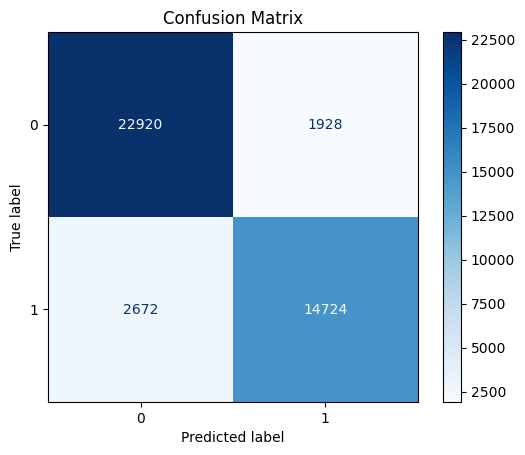

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.8911087965154815
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     24848
           1       0.88      0.85      0.86     17396

    accuracy                           0.89     42244
   macro avg       0.89      0.88      0.89     42244
weighted avg       0.89      0.89      0.89     42244



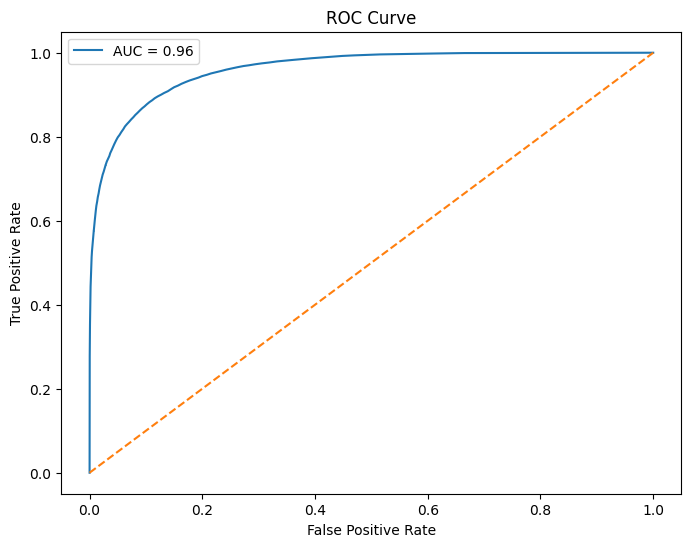

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define and train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
